# About SpaceNet

[SpaceNet](https://spacenetchallenge.github.io/) is a corpus of commercial satellite imagery and labeled training data to use for machine learning research. The dataset is currently hosted as an [Amazon Web Services (AWS) Public Dataset](https://aws.amazon.com/public-datasets/spacenet/).

The current SpaceNet corpus includes thousands of square kilometers of high resolution imagery collected from DigitalGlobe’s commercial satellites which includes 8-band multispectral data. This dataset is being made public to advance the development of algorithms to automatically extract geometric features such as roads, building footprints, and points of interest using satellite imagery. 

The currently available Areas of Interest (AOI) are:
- Rio de Janeiro
- Paris
- Las Vegas
- Shanghai
- Khartoum. 

The satellite imagery, along with training data, is provided via a collaboration between DigitalGlobe, CosmiQ Works, and NVIDIA.

# Rio de Janeiro labelled satellite imagery from SpaceNet

See https://spacenetchallenge.github.io/AOI_Lists/AOI_1_Rio.html

In [1]:
from IPython.display import HTML
url = 'https://spacenetchallenge.github.io/AOI_Lists/AOI_1_Rio.html'
iframe = '<iframe src=' + url + ' width=100% height=600></iframe>'
HTML(iframe)

# Set up Amazon Web Services Command Line Interface

In order to download the dataset, you'll need to install and configure the AWS command line interface.

See here: https://aws.amazon.com/cli/

First, pip install the aws command line interface:

In [2]:
#!pip install awscli

Next, configure the cli with you access key and secret access key from AWS console.

Something like this:

    !aws configure
    AWS Access Key ID [None]: "YOUR ACCESS KEY"
    AWS Secret Access Key [None]: "YOUR SECRET ACCESS KEY"
    Default region name [None]: us-west-2
    Default output format [None]: json

# View the contents of the dataset

In [3]:
!aws s3 ls spacenet-dataset/AOI_1_Rio/ --request-payer requester

                           PRE processedData/
                           PRE srcData/
                           PRE vectorData/


# Download the data

Download 200m x 200m tiles of AOI (3.4 GB) and building footprints

In [ ]:
%%time
!aws s3api get-object --bucket spacenet-dataset --key AOI_1_Rio/processedData/processedBuildingLabels.tar.gz --request-payer requester processedBuildingLabels.tar.gz

# Unzip the data

Unzip the main folder

In [ ]:
!tar -xvzf processedBuildingLabels.tar.gz

Unzip the 3band satellite images

In [ ]:
!tar -xvzf processedBuildingLabels/3band.tar.gz

Unzip the geojson containing labels

In [ ]:
!tar -xvzf processedBuildingLabels/vectordata/geojson.tar.gz

# How many images are there?

In [2]:
import os
from os.path import join

In [3]:
images_folder = "3band"
labels_folder = "geojson"

In [4]:
print(len([name for name in os.listdir(images_folder)]), "satellite images")

6940 satellite images


In [5]:
print(len([name for name in os.listdir(labels_folder)]), "geojson labels")

6940 geojson labels


# Read a few of the images into arrays

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

Try reading the first image.

In [7]:
img=np.array(Image.open(join(images_folder, os.listdir(images_folder)[0])))

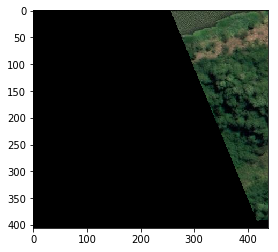

In [8]:
plt.imshow(img);

Here is the last image.

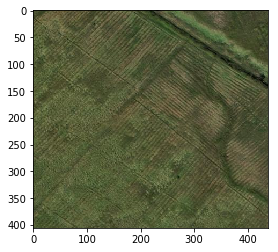

In [9]:
plt.imshow(np.array(Image.open(join(images_folder, os.listdir(images_folder)[-1]))));

# Read all the images into list of arrays

Converting to grayscale as they are opened.

In [10]:
images = [np.array(Image.open(join(images_folder, i)).convert('L')) for i in os.listdir(images_folder)]

In [11]:
print(len(images), "images")

6940 images


# Resize some of the images so that they are all the same size

Some images have shape of (406, 438), others have shape of (406, 439).

Change the (406, 439)'s to (406, 438).

In [12]:
for i in range(len(images)):
    if images[i].shape[1] == 439:
        images[i] = np.delete(images[i], 439-1, axis=1)

Change the (407, 438)'s to (406, 438)'s.

In [13]:
for i in range(len(images)):
    if images[i].shape[0] == 407:
        images[i] = np.delete(images[i], 407-1, axis=0)

# Downsample the images so they are smaller.

In [14]:
from skimage.transform import downscale_local_mean

4x downsampling.

In [15]:
downscaled_images = []
for i in range(len(images)):
    downscaled_images.append(downscale_local_mean(images[i], (4,4)))

In [16]:
downscaled_images[0].shape

(102, 110)

Original image:

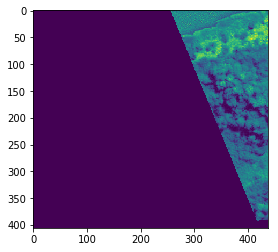

In [17]:
plt.imshow(images[0]);

Downscaled image:

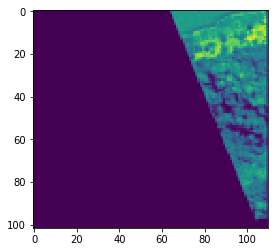

In [18]:
plt.imshow(downscaled_images[0]);

# Convert this list of downscaled arrays into a 3D array

In [19]:
shape = list(downscaled_images[0].shape)
shape[:0] = [len(downscaled_images)]
array_of_images = np.concatenate(downscaled_images).reshape(shape)

In [20]:
array_of_images.shape

(6940, 102, 110)

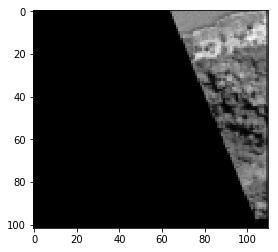

In [21]:
plt.imshow(array_of_images[0], cmap="gray");

# Parse the geojson labels for 1 = building, 0 = no building

In [22]:
import json

Read in all the geojsons.

In [23]:
labels = [json.load(open(join(labels_folder, i))) for i in os.listdir(labels_folder)]

# Create an array containing 1 = buildings, 0 = no buildings

In [24]:
def parse_labels(labels):
    
    results = []
    
    for label in labels:
        
        features = label['features']
        
        # If no features at all, append 0
        if len(features) == 0:
            results.append(0)
            
        # Otherwise, look for building property
        else:
            buildings_in_this_label = []
            for feature in features:
                properties = feature['properties']
                if 'building' in properties.keys():
                    if properties['building'] == 'yes':
                        buildings_in_this_label.append(1)
                    else:
                        buildings_in_this_label.append(0)
                else:
                    buildings_in_this_label.append(0)
            
            # If there is at least one building in this label, append 1
            if sum(buildings_in_this_label) > 0:
                results.append(1)
                
            # Otherwise append 0
            else:
                results.append(0)
                        
    array = np.array(results)
    return array

In [25]:
buildings_no_buildings = parse_labels(labels)

In [26]:
print(buildings_no_buildings.sum(), "of the", buildings_no_buildings.shape[0], "images contain buildings")

4302 of the 6940 images contain buildings


# Frame this as a machine learning problem

In [27]:
X = array_of_images
y = buildings_no_buildings

In [28]:
X.shape

(6940, 102, 110)

In [29]:
y.shape

(6940,)

# Split data into training and testing data

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
X_train.shape

(5205, 102, 110)

In [33]:
y_train.shape

(5205,)

In [34]:
X_test.shape

(1735, 102, 110)

In [35]:
y_test.shape

(1735,)

# Convolutional Neural Network

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [270]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# reshape to be [samples][bands][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, X_train[0].shape[0], X_train[0].shape[1]).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, X_test[0].shape[0], X_test[0].shape[1]).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# convert label arrays to categorical
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [39]:
# define the model
def cnn():
    model = Sequential()
    
    model.add(Conv2D(50, (5, 5), input_shape=(1, X_train.shape[2], X_train.shape[3]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [40]:
%%time
# build the model
model = cnn()
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 5205 samples, validate on 1735 samples
Epoch 1/10
 - 255s - loss: 0.5089 - acc: 0.7126 - val_loss: 0.5462 - val_acc: 0.7037
Epoch 2/10
 - 215s - loss: 0.3078 - acc: 0.8699 - val_loss: 0.3012 - val_acc: 0.8744
Epoch 3/10
 - 216s - loss: 0.2883 - acc: 0.8782 - val_loss: 0.2840 - val_acc: 0.8761
Epoch 4/10
 - 215s - loss: 0.2721 - acc: 0.8855 - val_loss: 0.2590 - val_acc: 0.8939
Epoch 5/10
 - 215s - loss: 0.2495 - acc: 0.8968 - val_loss: 0.2526 - val_acc: 0.8928
Epoch 6/10
 - 216s - loss: 0.2430 - acc: 0.9003 - val_loss: 0.2639 - val_acc: 0.8968
Epoch 7/10
 - 214s - loss: 0.2493 - acc: 0.8955 - val_loss: 0.2718 - val_acc: 0.8916
Epoch 8/10
 - 214s - loss: 0.2331 - acc: 0.9039 - val_loss: 0.2843 - val_acc: 0.8859
Epoch 9/10
 - 215s - loss: 0.2468 - acc: 0.9020 - val_loss: 0.2495 - val_acc: 0.8968
Epoch 10/10
 - 214s - loss: 0.2287 - acc: 0.9099 - val_loss: 0.2403 - val_acc: 0.8974
Large CNN Error: 10.26%
CPU times: user 3h 55min, sys: 14min 31s, total: 4h 9min 31s
Wall time: 37min

In [63]:
# save model
model_name = "building_no_building"

model.save(join("models", model_name + ".h5"))

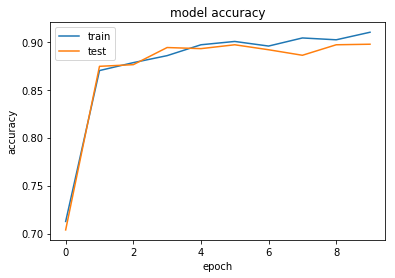

In [41]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

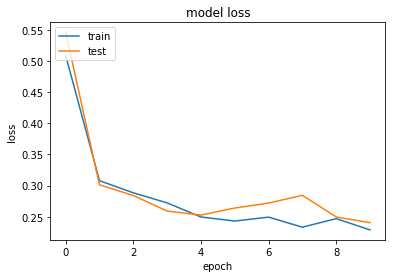

In [42]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [232]:
y_pred = model.predict_classes(X_test, batch_size=10)

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [250]:
y_test

array([1, 0, 0, ..., 1, 1, 0])

In [251]:
y_pred

array([1, 0, 0, ..., 1, 1, 0])

Confusion matrix.

In [269]:
confusion_matrix(y_test, y_pred)

array([[596,  71],
       [107, 961]])

# View the first 50 predictions

In [234]:
def view_prediction_vs_actual(i, y_pred, X=X, y=y):
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.25, random_state=42)
    
    f, ax = plt.subplots()
    plt.imshow(X_test_orig[i], cmap='gray')
    
    prediction = ['no_building', 'building'][y_pred[i]]
    actual = ['no_building', 'building'][y_test_orig[i]]
    
    if prediction == actual:
        ax.annotate("CORRECT", (5,90), color='white', weight='bold',fontsize=16, bbox={'facecolor':'green', 'alpha':0.9, 'pad':5})
    else:
        ax.annotate("INCORRECT", (5,90), color='white', weight='bold',fontsize=16, bbox={'facecolor':'red', 'alpha':0.9, 'pad':5})
    
    ax.annotate("prediction:  " + prediction, (5, 10), color='white', weight='bold',fontsize=16)
    ax.annotate("actual:  " + actual, (5, 20), color='white', weight='bold',fontsize=16)
    
    return f

/anaconda/envs/building_detection/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


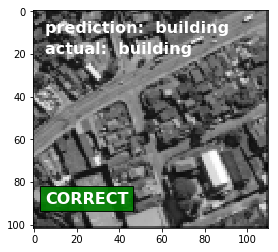

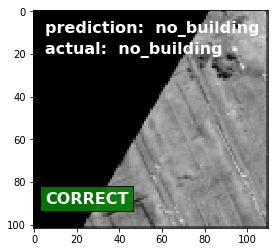

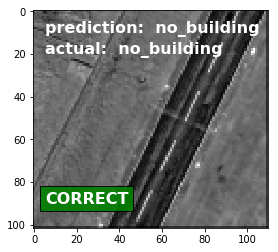

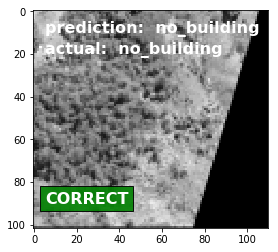

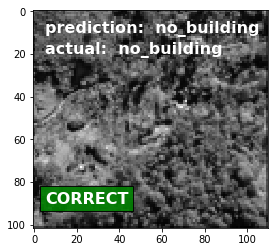

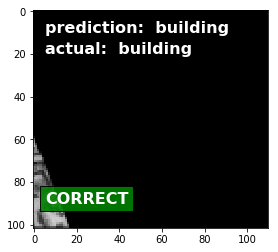

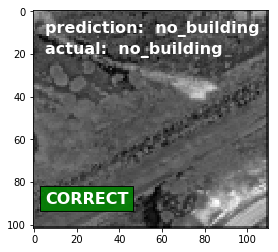

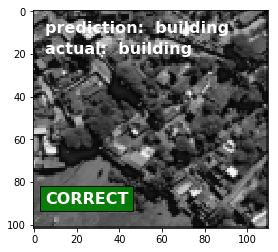

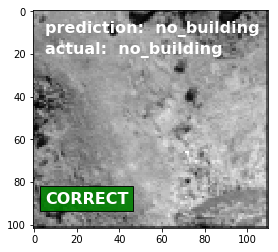

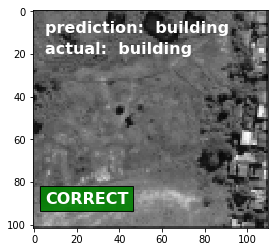

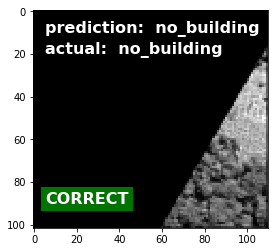

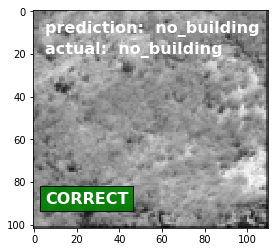

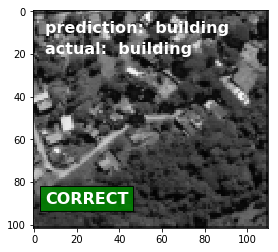

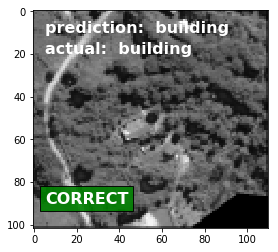

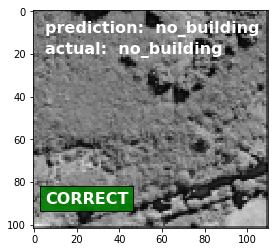

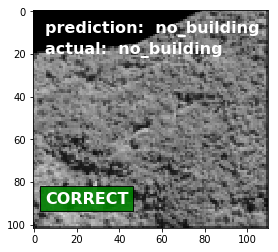

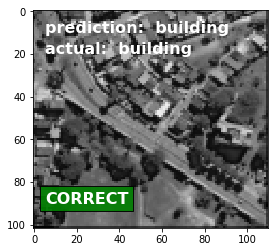

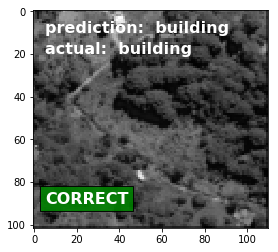

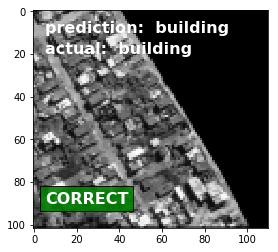

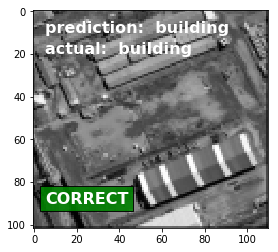

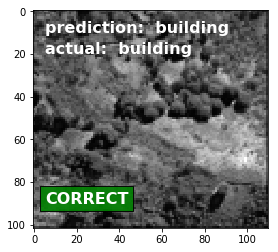

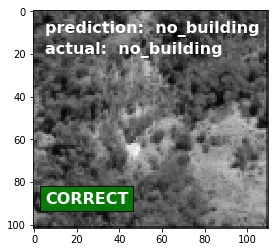

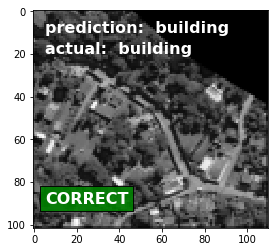

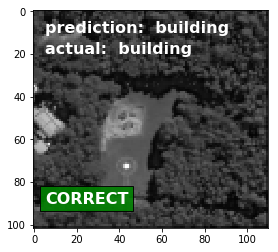

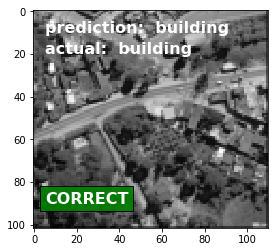

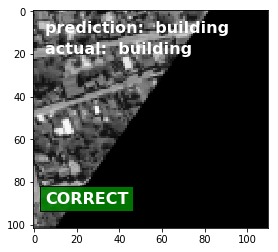

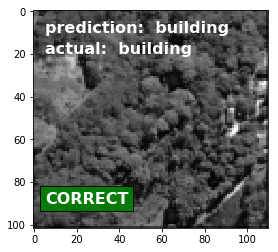

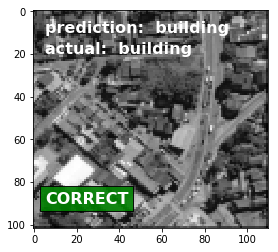

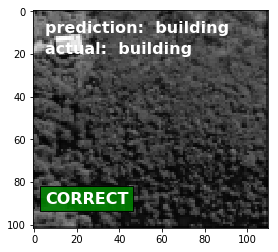

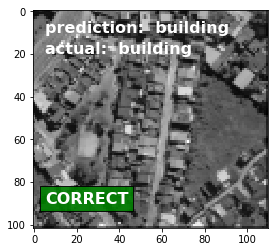

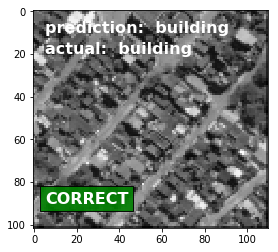

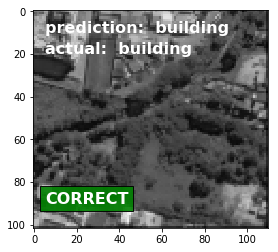

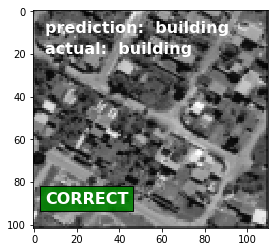

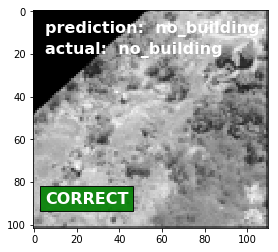

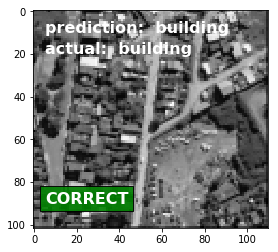

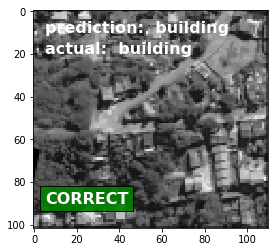

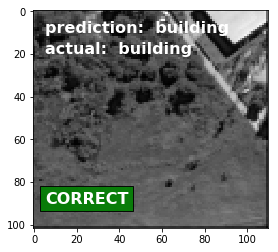

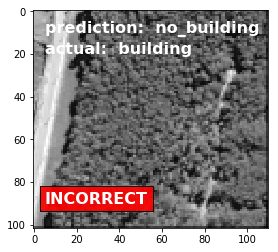

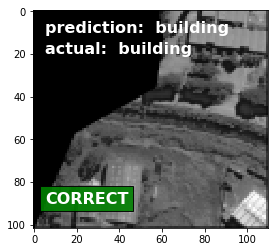

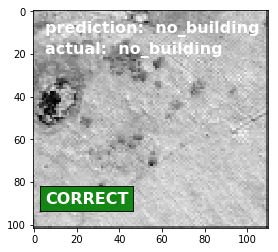

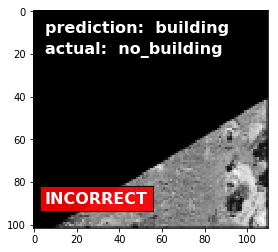

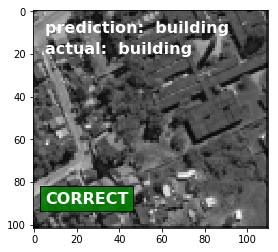

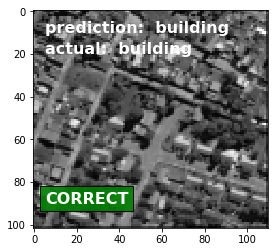

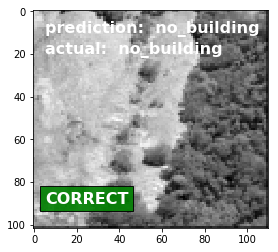

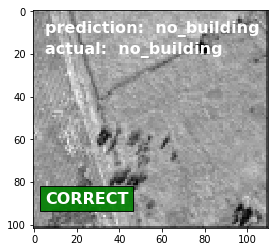

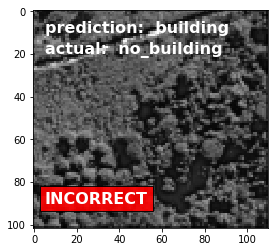

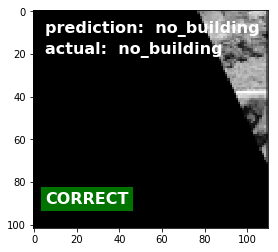

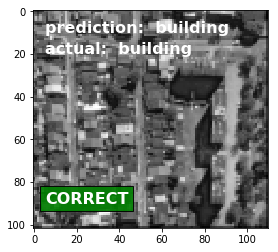

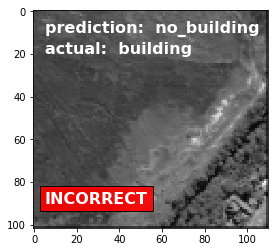

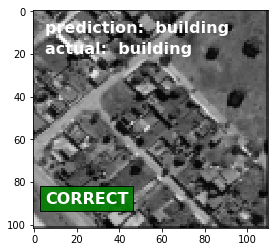

In [235]:
for i in range(50):
    
    view_prediction_vs_actual(i, y_pred)

# View the last 50 predictions

/anaconda/envs/building_detection/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


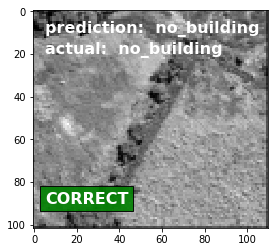

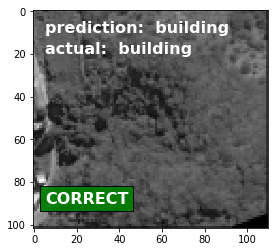

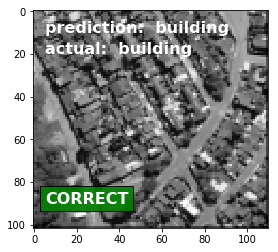

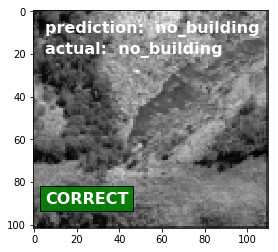

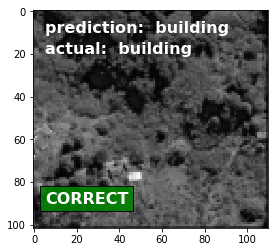

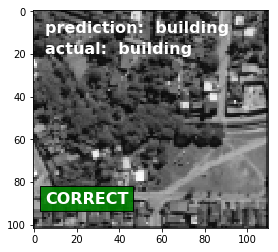

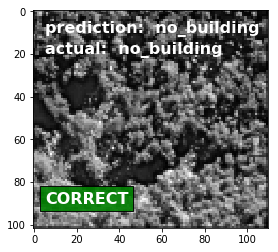

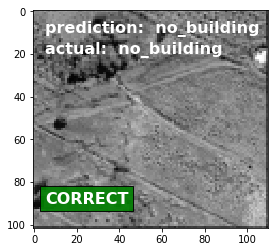

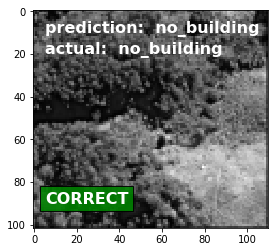

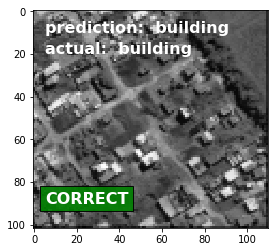

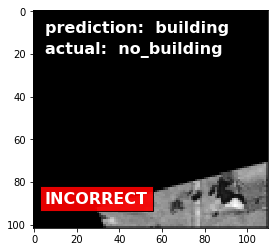

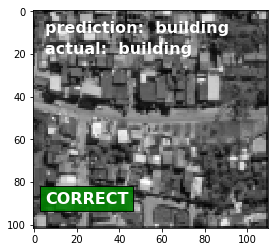

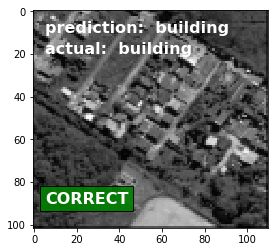

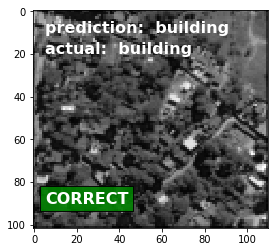

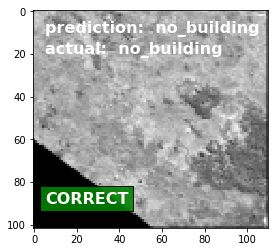

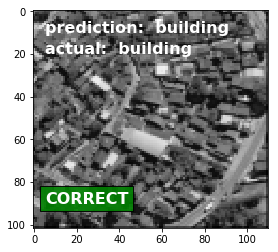

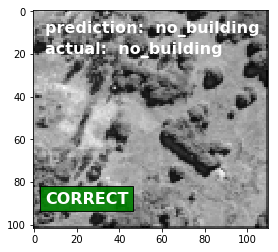

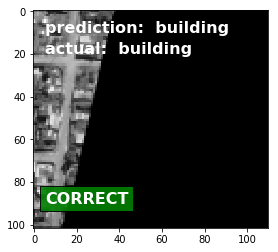

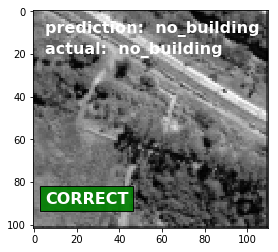

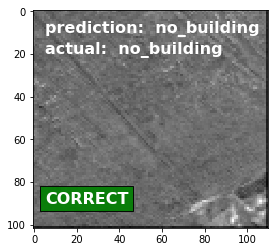

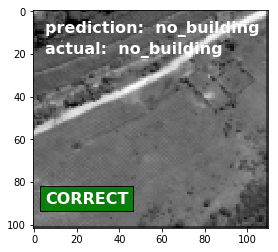

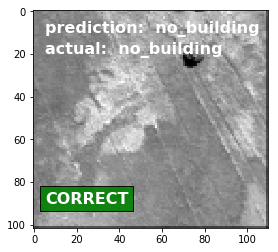

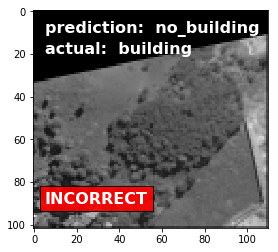

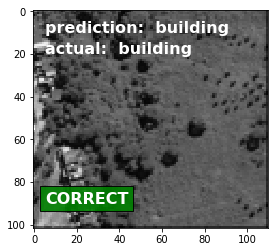

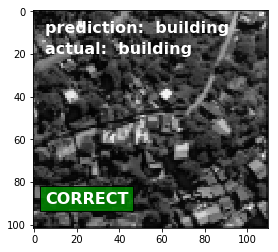

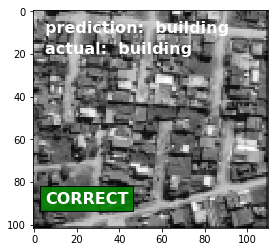

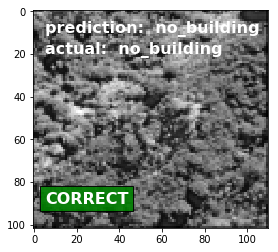

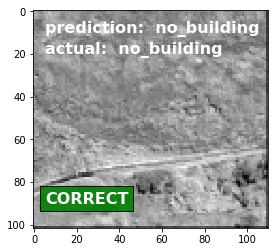

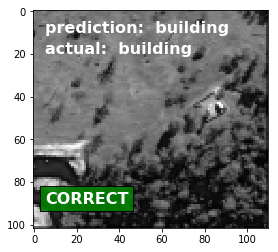

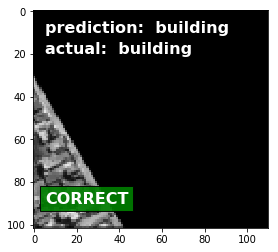

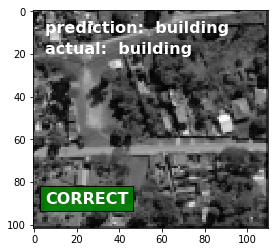

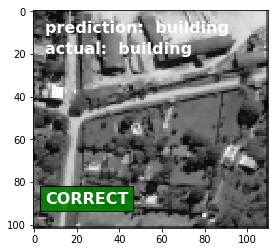

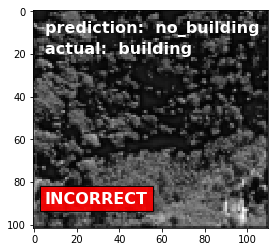

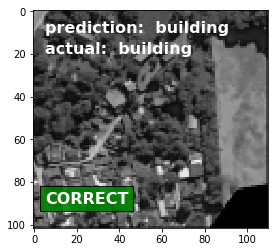

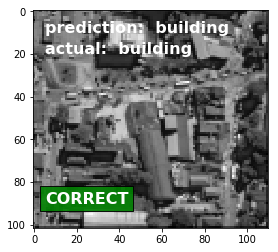

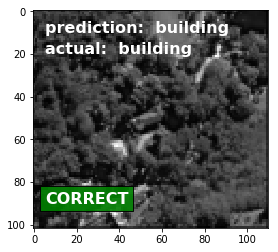

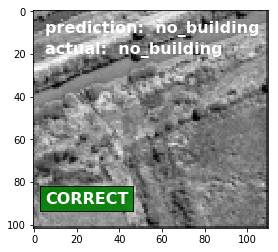

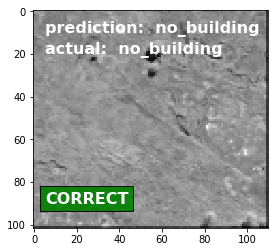

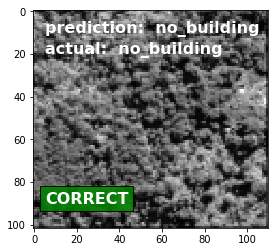

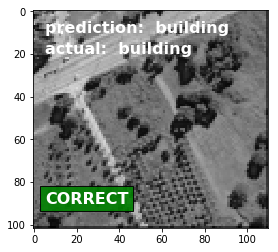

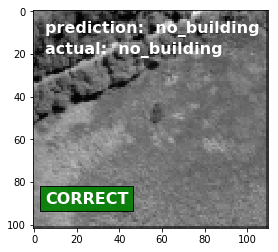

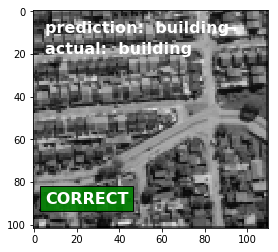

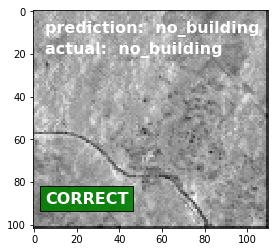

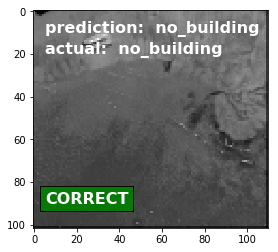

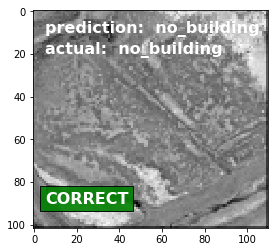

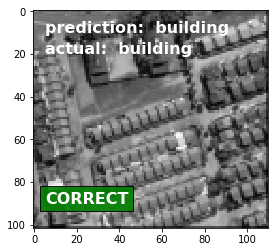

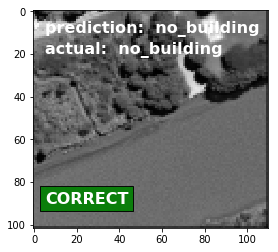

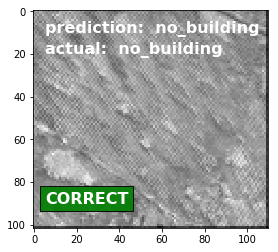

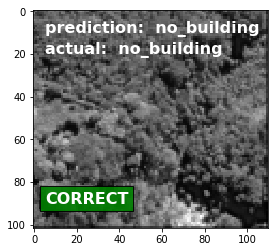

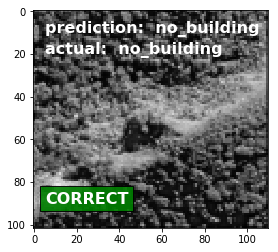

In [236]:
for i in range(len(predictions)-1, len(predictions) - 51, -1):
    
    view_prediction_vs_actual(i, y_pred)